KNN Regression Results:
k =  1 -> RMSE = 1.7238
k =  2 -> RMSE = 1.4895
k =  3 -> RMSE = 1.3776
k =  4 -> RMSE = 1.3535
k =  5 -> RMSE = 1.3189
k =  6 -> RMSE = 1.3144
k =  7 -> RMSE = 1.3145
k =  8 -> RMSE = 1.3012
k =  9 -> RMSE = 1.2968
k = 10 -> RMSE = 1.2857
k = 11 -> RMSE = 1.2872
k = 12 -> RMSE = 1.2818
k = 13 -> RMSE = 1.2762
k = 14 -> RMSE = 1.2718
k = 15 -> RMSE = 1.2715
k = 16 -> RMSE = 1.2688
k = 17 -> RMSE = 1.2722
k = 18 -> RMSE = 1.2696
k = 19 -> RMSE = 1.2681
k = 20 -> RMSE = 1.2673
k = 21 -> RMSE = 1.2669
k = 22 -> RMSE = 1.2680
k = 23 -> RMSE = 1.2709
k = 24 -> RMSE = 1.2711
k = 25 -> RMSE = 1.2721
k = 26 -> RMSE = 1.2698
k = 27 -> RMSE = 1.2708
k = 28 -> RMSE = 1.2706
k = 29 -> RMSE = 1.2715
k = 30 -> RMSE = 1.2734
k = 31 -> RMSE = 1.2779
k = 32 -> RMSE = 1.2768
k = 33 -> RMSE = 1.2771
k = 34 -> RMSE = 1.2795
k = 35 -> RMSE = 1.2817
k = 36 -> RMSE = 1.2846
k = 37 -> RMSE = 1.2839
k = 38 -> RMSE = 1.2829
k = 39 -> RMSE = 1.2837
k = 40 -> RMSE = 1.2820
k = 41 -> RMSE =

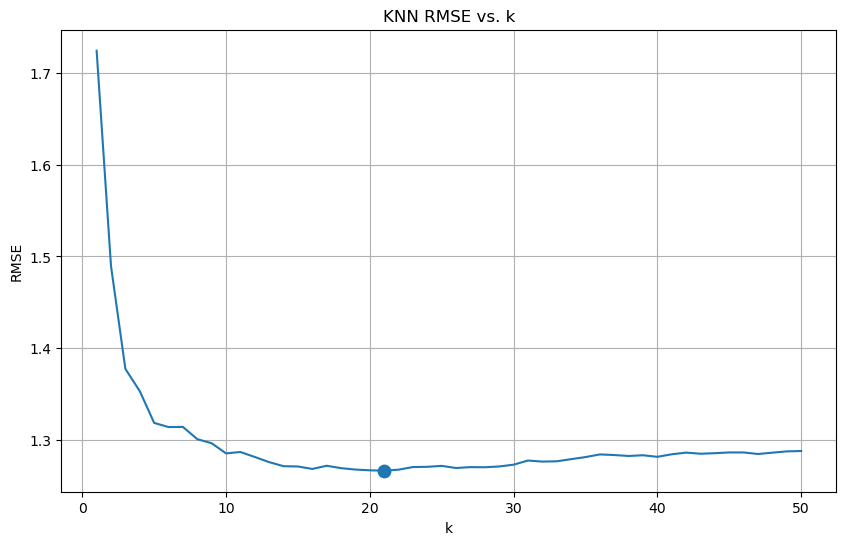

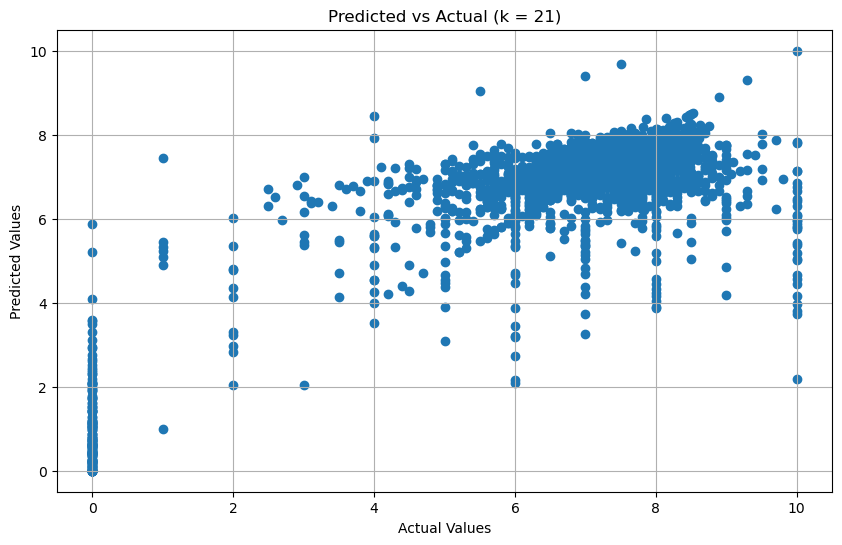

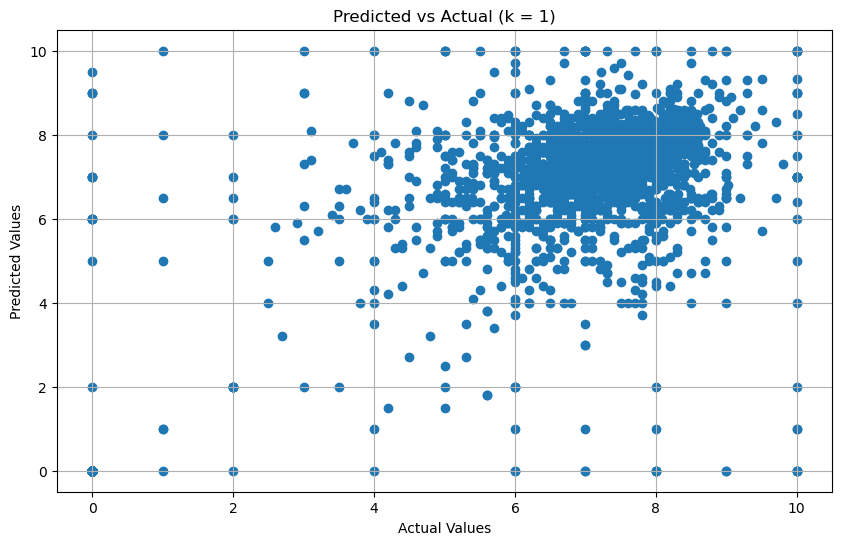

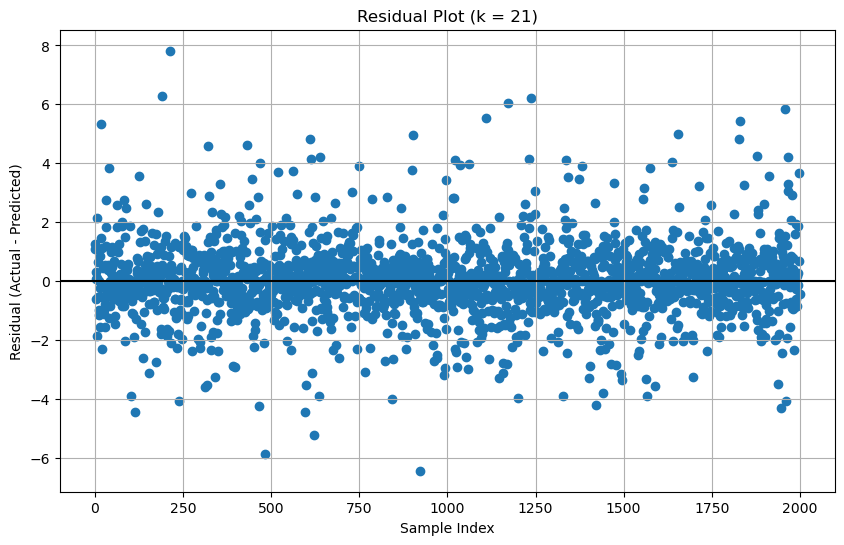

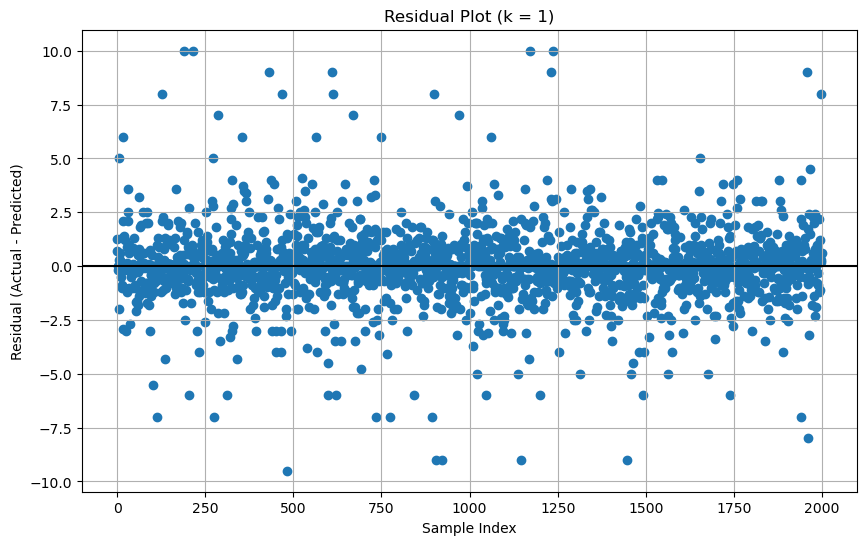

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

data = pd.read_csv('data/10k_Poplar_Tv_Shows.csv')

# data dropped
data = data.drop(columns=['adult'])
data = data.drop(columns=['backdrop_path']) #always drop
data = data.drop(columns=['id']) #always drop
data = data.drop(columns=['original_name']) #always drop
data = data.drop(columns=['overview']) # always drop
data = data.drop(columns=['poster_path']) #always drop
data = data.drop(columns=['first_air_date'])
data = data.drop(columns=['name']) #always drop

# data being used 'origin_country', 'original_language', 'popularity', 'genre_ids', 'vote_average', 'vote_count'

# convert the list-like entry to actual lists or a empty list
data['genre_ids'] = data['genre_ids'].apply(lambda x: eval(x) if isinstance(x, str) else [])

# expand the list of genres 
data_exploded_genres = data.explode('genre_ids')
# encode every column
dummy_genres = pd.get_dummies(data_exploded_genres['genre_ids'], prefix='genre', dtype=int)
dummy_genres = dummy_genres.groupby(dummy_genres.index).sum()
data = data.merge(dummy_genres, left_index=True, right_index=True, how='left')
# all "exploded" columns start with genre as specified by the option prefix='genre'
genre_cols = [col for col in data.columns if col.startswith('genre_')]
data[genre_cols] = data[genre_cols].fillna(0)
data = data.drop(columns=['genre_ids'])


# convert the list-like entry to actual lists or a empty list
data['origin_country'] = data['origin_country'].apply(lambda x: eval(x) if isinstance(x, str) else [])

# expand the list of countries
data_exploded_countries = data.explode('origin_country')
# encode every column
dummy_countries = pd.get_dummies(data_exploded_countries['origin_country'], prefix='country', dtype=int)
dummy_countries = dummy_countries.groupby(dummy_countries.index).sum()
data = data.merge(dummy_countries, left_index=True, right_index=True, how='left')
# all "exploded" columns start with country as specified by the option prefix='country'
country_cols = [col for col in data.columns if col.startswith('country_')]
data[country_cols] = data[country_cols].fillna(0)
data = data.drop(columns=['origin_country'])


data = pd.get_dummies(data, columns=['original_language'], prefix='lang', dtype=int)

data.dropna(inplace=True)


# everything but vote_average
feature_columns = ['popularity', 'vote_count'] + [col for col in data.columns if col.startswith('genre_')] + [col for col in data.columns if col.startswith('country_')] +  [col for col in data.columns if col.startswith('lang_')]

X = data[feature_columns]
y = data['vote_average']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=444)

#--------------------------------------------------------------------------------------------------------------------
k_values = list(range(1, 51))
rmse_values = []
all_predictions = {}

print("KNN Regression Results:")

for k in k_values:
    knn = KNeighborsRegressor(
        n_neighbors=k,
        metric="euclidean",
        weights="distance"
    )

    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)

    # store predictions for optional plots
    all_predictions[k] = y_pred
    
    print(f"k = {k:2d} -> RMSE = {rmse:.4f}")

# -----------------------------
# 1. Plot RMSE vs k
# -----------------------------
best_k = k_values[np.argmin(rmse_values)]
best_rmse = min(rmse_values)

plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_values)
plt.scatter([best_k], [best_rmse], s=80)
plt.xlabel("k")
plt.ylabel("RMSE")
plt.title("KNN RMSE vs. k")
plt.grid(True)
plt.show()

# -----------------------------
# 2. Plot predicted vs actual (best k)
# -----------------------------
best_predictions = all_predictions[best_k]

plt.figure(figsize=(10,6))
plt.scatter(y_test, best_predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Predicted vs Actual (k = {best_k})")
plt.grid(True)
plt.show()

# -----------------------------
# 2.5. Plot residual errors (k = 1)
# -----------------------------
k_predictions = all_predictions[1]

plt.figure(figsize=(10,6))
plt.scatter(y_test, k_predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Predicted vs Actual (k = 1)")
plt.grid(True)
plt.show()
# -----------------------------
# 3. Plot residual errors (best k)
# -----------------------------
residuals = y_test - best_predictions

plt.figure(figsize=(10,6))
plt.scatter(range(len(residuals)), residuals)
plt.axhline(0, color='black')
plt.xlabel("Sample Index")
plt.ylabel("Residual (Actual - Predicted)")
plt.title(f"Residual Plot (k = {best_k})")
plt.grid(True)
plt.show()
# -----------------------------
# 3.5 Plot residual errors (k = 1)
# -----------------------------
residuals = y_test - all_predictions[1]

plt.figure(figsize=(10,6))
plt.scatter(range(len(residuals)), residuals)
plt.axhline(0, color='black')
plt.xlabel("Sample Index")
plt.ylabel("Residual (Actual - Predicted)")
plt.title(f"Residual Plot (k = 1)")
plt.grid(True)
plt.show()